<a href="https://colab.research.google.com/github/eghib22/Store-Sales-Forecasting/blob/main/model_experiment_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ekaterineghibradze","key":"a8a365ed14425b41a5b7d099017ca8f5"}'}

In [17]:
!mv "kaggle.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

y
mv: cannot stat 'kaggle.json': No such file or directory


In [6]:
!ls -l ~/.kaggle/

total 4
-rw------- 1 root root 74 Jul  2 14:29 kaggle.json


In [7]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 748MB/s]


In [8]:
! unzip walmart-recruiting-store-sales-forecasting

Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [9]:
!unzip '*.csv.zip'

Archive:  sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    

Archive:  features.csv.zip
  inflating: features.csv            

Archive:  train.csv.zip
  inflating: train.csv               

Archive:  test.csv.zip
  inflating: test.csv                

4 archives were successfully processed.


In [10]:
!unzip '*.csv.zip'

Archive:  sampleSubmission.csv.zip
replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sampleSubmission.csv    

Archive:  features.csv.zip
replace features.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: features.csv            

Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               

Archive:  test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                

4 archives were successfully processed.


In [11]:
import pandas as pd

# Load the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')
sample_submission = pd.read_csv('sampleSubmission.csv')

# Explore the data
print("Train shape:", train.shape)
print(train.head())
print(train.columns)

print("\nTest shape:", test.shape)
print(test.head())
print(test.columns)

print("\nFeatures shape:", features.shape)
print(features.head())
print(features.columns)

print("\nStores shape:", stores.shape)
print(stores.head())
print(stores.columns)

print("\nSample Submission shape:", sample_submission.shape)
print(sample_submission.head())
print(sample_submission.columns)

Train shape: (421570, 5)
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')

Test shape: (115064, 4)
   Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012-11-09      False
2      1     1  2012-11-16      False
3      1     1  2012-11-23       True
4      1     1  2012-11-30      False
Index(['Store', 'Dept', 'Date', 'IsHoliday'], dtype='object')

Features shape: (8190, 12)
   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        3

In [12]:
# Merge train and test with features and stores
train_merged = pd.merge(train, features, on=['Store', 'Date'], how='left')
train_merged = pd.merge(train_merged, stores, on='Store', how='left')

test_merged = pd.merge(test, features, on=['Store', 'Date'], how='left')
test_merged = pd.merge(test_merged, stores, on='Store', how='left')

# Convert Date to datetime
train_merged['Date'] = pd.to_datetime(train_merged['Date'])


In [13]:
# Split
train_data = train_merged[train_merged['Date'] < '2012-01-01']
val_data = train_merged[(train_merged['Date'] >= '2012-01-01') & (train_merged['Date'] < '2012-07-01')]
test_data = train_merged[train_merged['Date'] >= '2012-07-01']

print("Train:", train_data.shape)
print("Validation:", val_data.shape)
print("Test (local):", test_data.shape)

Train: (294132, 17)
Validation: (77110, 17)
Test (local): (50328, 17)


<class 'pandas.core.frame.DataFrame'>
Index: 294132 entries, 0 to 421526
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         294132 non-null  int64         
 1   Dept          294132 non-null  int64         
 2   Date          294132 non-null  datetime64[ns]
 3   Weekly_Sales  294132 non-null  float64       
 4   IsHoliday_x   294132 non-null  bool          
 5   Temperature   294132 non-null  float64       
 6   Fuel_Price    294132 non-null  float64       
 7   MarkDown1     23700 non-null   float64       
 8   MarkDown2     20154 non-null   float64       
 9   MarkDown3     23116 non-null   float64       
 10  MarkDown4     21042 non-null   float64       
 11  MarkDown5     23994 non-null   float64       
 12  CPI           294132 non-null  float64       
 13  Unemployment  294132 non-null  float64       
 14  IsHoliday_y   294132 non-null  bool          
 15  Type          294132 n

<Axes: >

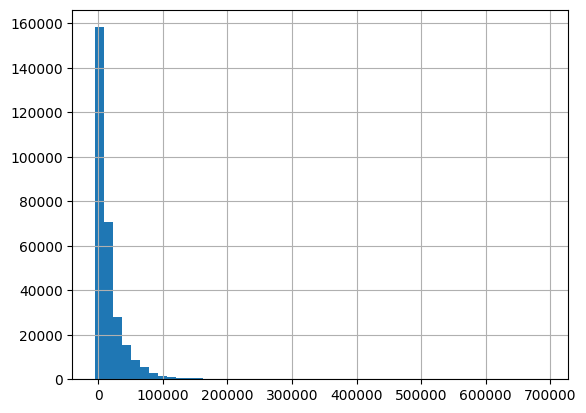

In [14]:
print(train_data.info())
print(train_data.describe())
print(train_data.isnull().sum())
train_data['Weekly_Sales'].hist(bins=50)

In [15]:
def preprocess(df):
    # Encode categorical
    type_map = {'A': 0, 'B': 1, 'C': 2}
    df = df.copy()  # Avoid SettingWithCopyWarning
    df['Type'] = df['Type'].map(type_map)
    # Rename IsHoliday_x to IsHoliday and drop IsHoliday_y
    if 'IsHoliday_x' in df.columns:
        df['IsHoliday'] = df['IsHoliday_x'].astype(int)
        df = df.drop(columns=['IsHoliday_x', 'IsHoliday_y'])
    elif 'IsHoliday' in df.columns: # Handle the case where the input is the test_merged
        df['IsHoliday'] = df['IsHoliday'].astype(int)


    # Date features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    df['Day'] = df['Date'].dt.day
    # Fill MarkDown NaNs
    markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
    for col in markdown_cols:
        if col in df.columns:
            df[col] = df[col].fillna(0)
    # Drop Date column
    df = df.drop(columns=['Date'])
    return df

In [18]:
from sklearn.preprocessing import FunctionTransformer
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Preprocessing transformer
preprocess_transformer = FunctionTransformer(preprocess)

# Preprocess train and validation data FIRST (outside pipeline)
X_train = preprocess(train_data.drop(columns=['Weekly_Sales']))
y_train = train_data['Weekly_Sales']

val_data_processed = preprocess(val_data)  # Preprocess val_data

X_val = val_data_processed.drop(columns=['Weekly_Sales'])
y_val = val_data_processed['Weekly_Sales']

# WMAE weights
weights_val = val_data_processed['IsHoliday'].apply(lambda x: 5 if x else 1)

# Build and train the model directly (since we've already preprocessed)
model = xgb.XGBRegressor(random_state=42, n_estimators=1000, verbosity=1)
model.fit(X_train, y_train)

# Predict on validation set
y_pred = model.predict(X_val)

# WMAE calculation
wmae = np.sum(weights_val * np.abs(y_val - y_pred)) / np.sum(weights_val)
print("Validation WMAE:", wmae)


Validation WMAE: 2840.5109471920646
